# Liesel-GAM Demo Notebook

## Setup and Imports

In [22]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import numpy as np
import pandas as pd
import plotnine as p9
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam
from liesel_gam.builder.consolidate_bases import consolidate_bases, evaluate_bases

In [2]:
def gen_tp_data(n=400, noise_sd=0.3, grid=False, seed=1):
    """
    Generate test data for tensor-product smooths.

    Parameters
    ----------
    n : int
        Number of samples (if grid=False).
    noise_sd : float
        Standard deviation of Gaussian noise.
    grid : bool
        If True, generate approximately n points on a regular grid.
        If False, generate random design points.
    seed : int
        Random seed.

    Returns
    -------
    pandas.DataFrame with columns: x, y, eta (signal), z (noisy response)
    """
    rng = np.random.default_rng(seed)

    # --- Design ----
    if grid:
        m = int(np.ceil(np.sqrt(n)))
        xs = np.linspace(0, 1, m)
        ys = np.linspace(0, 1, m)
        x, y = np.meshgrid(xs, ys, indexing="xy")
        x = x.ravel()
        y = y.ravel()
    else:
        x = rng.uniform(0, 1, n)
        y = rng.uniform(0, 1, n)

    # --- True non-separable smooth ----
    def f_true(x, y):
        return (
            1.5 * np.sin(2 * np.pi * x) * np.cos(3 * np.pi * y)
            + 0.8 * x * y
            + 2.0 * np.exp(-(((x - 0.65) ** 2) / 0.01 + ((y - 0.35) ** 2) / 0.06))
        )

    eta = f_true(x, y)
    z = eta + rng.normal(scale=noise_sd, size=len(eta))

    return pd.DataFrame({"x": x, "y": y, "eta": eta, "z": z})

In [3]:
df = gen_tp_data(n=600, noise_sd=0.25, grid=False, seed=42)
print(df.head())

          x         y       eta         z
0  0.773956  0.477506  0.935849  0.689560
1  0.438878  0.761433  0.621075  0.405865
2  0.858598  0.903328  1.334100  1.948456
3  0.697368  0.720696 -0.674870 -0.224435
4  0.094177  0.963211 -0.714339 -0.817277


In [4]:
df_grid = gen_tp_data(n=5000, grid=True)

In [5]:
df_grid

x    y           eta         z
0     0.000000  0.0  1.162528e-19  0.103675
1     0.014286  0.0  1.344590e-01  0.380944
2     0.028571  0.0  2.678353e-01  0.366966
3     0.042857  0.0  3.990553e-01  0.008108
4     0.057143  0.0  5.270622e-01  0.798669
...        ...  ...           ...       ...
5036  0.942857  1.0  1.281348e+00  1.076909
5037  0.957143  1.0  1.164770e+00  1.171729
5038  0.971429  1.0  1.044978e+00  1.027468
5039  0.985714  1.0  9.230304e-01  0.818835
5040  1.000000  1.0  8.000000e-01  0.129013

[5041 rows x 4 columns]

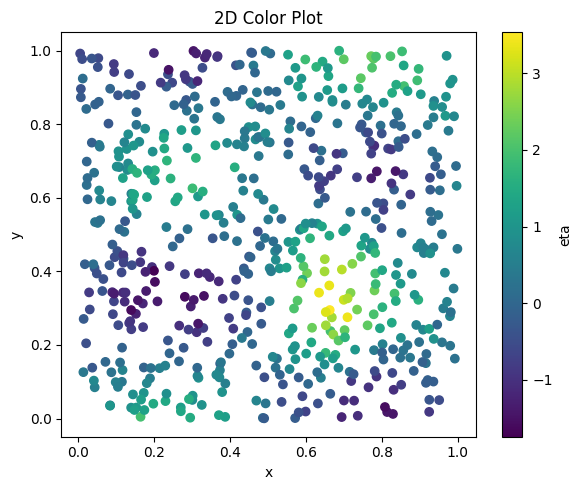

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df["x"], df["y"], c=df["z"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

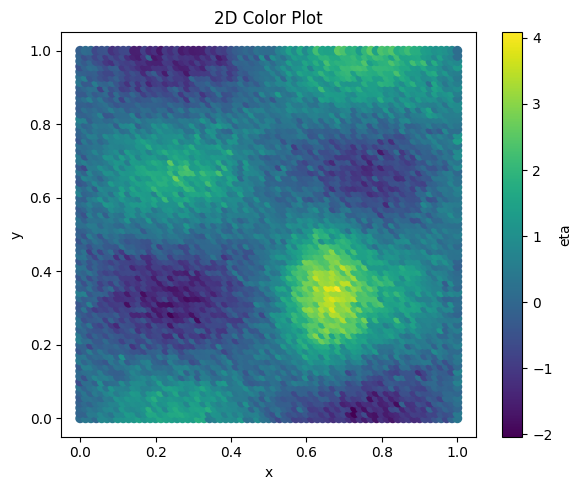

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df_grid["x"], df_grid["y"], c=df_grid["z"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

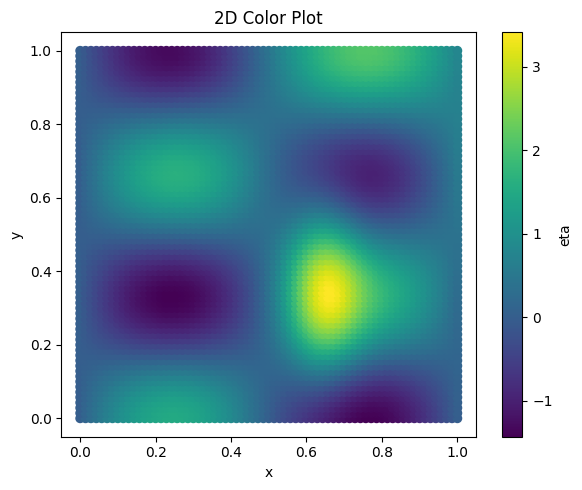

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.scatter(df_grid["x"], df_grid["y"], c=df_grid["eta"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

## Model Definition

### Setup response model

In [9]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


z = lsl.Var.new_obs(
    value=df.z.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="z",
)

In [10]:
tb = gam.TermBuilder.from_df(df)

In [11]:
loc += (
    tb.ti(
        "x",
        "y",
        k=10,
        scale=gam.ScaleIG(1.0, 1.0, 0.0005),
    ),
    tb.ps("x", k=20),
    tb.ps("y", k=20),
)

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="z_value").value


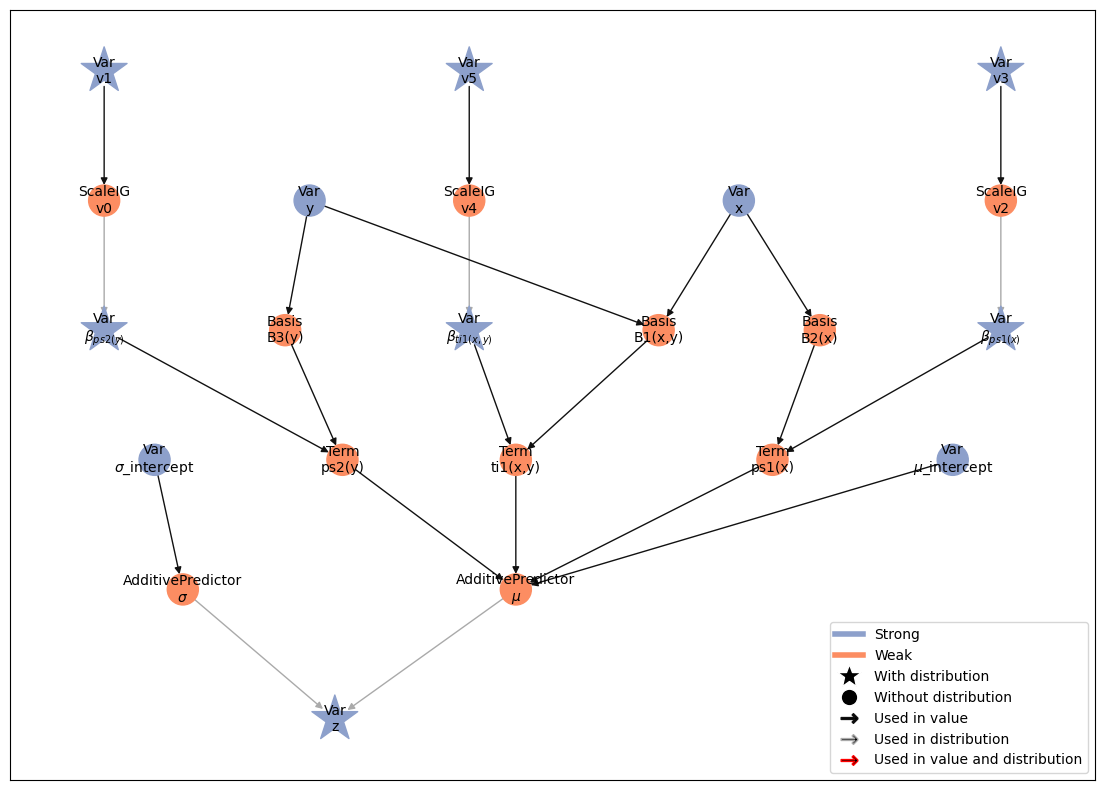

In [12]:
model = lsl.Model([z])
model.plot_vars()

In [13]:
model, bases_model = consolidate_bases(model)

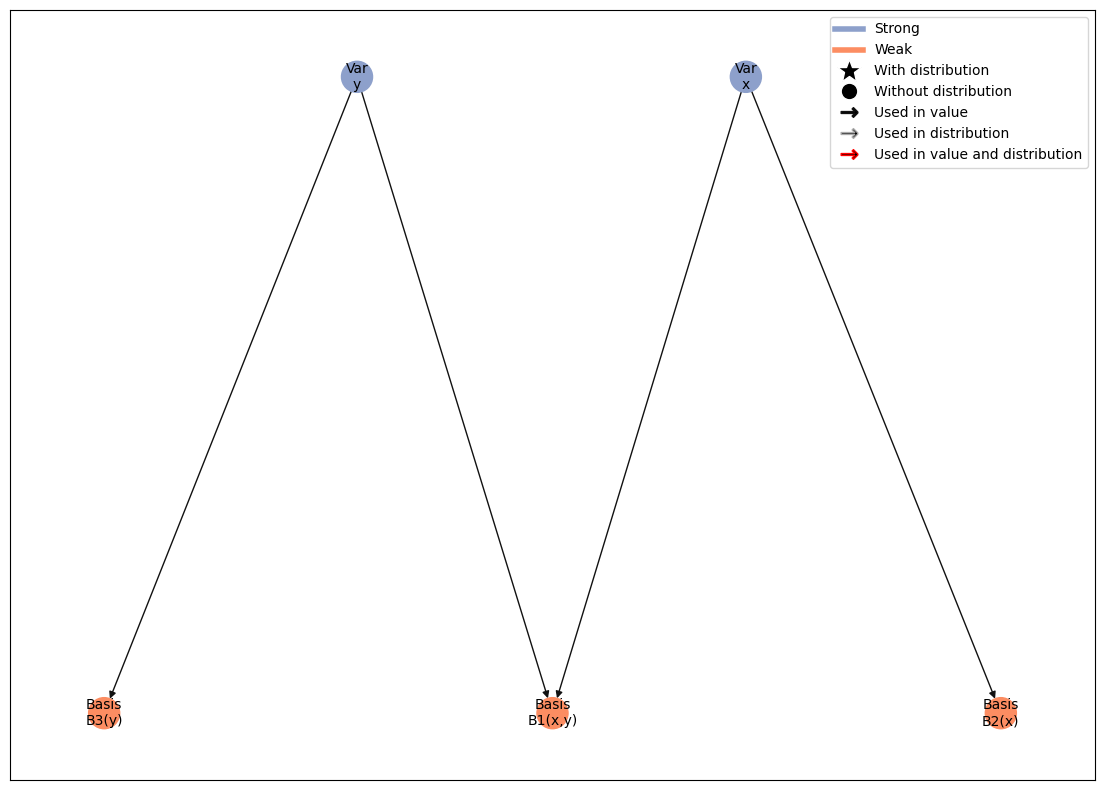

In [14]:
bases_model.plot_vars()

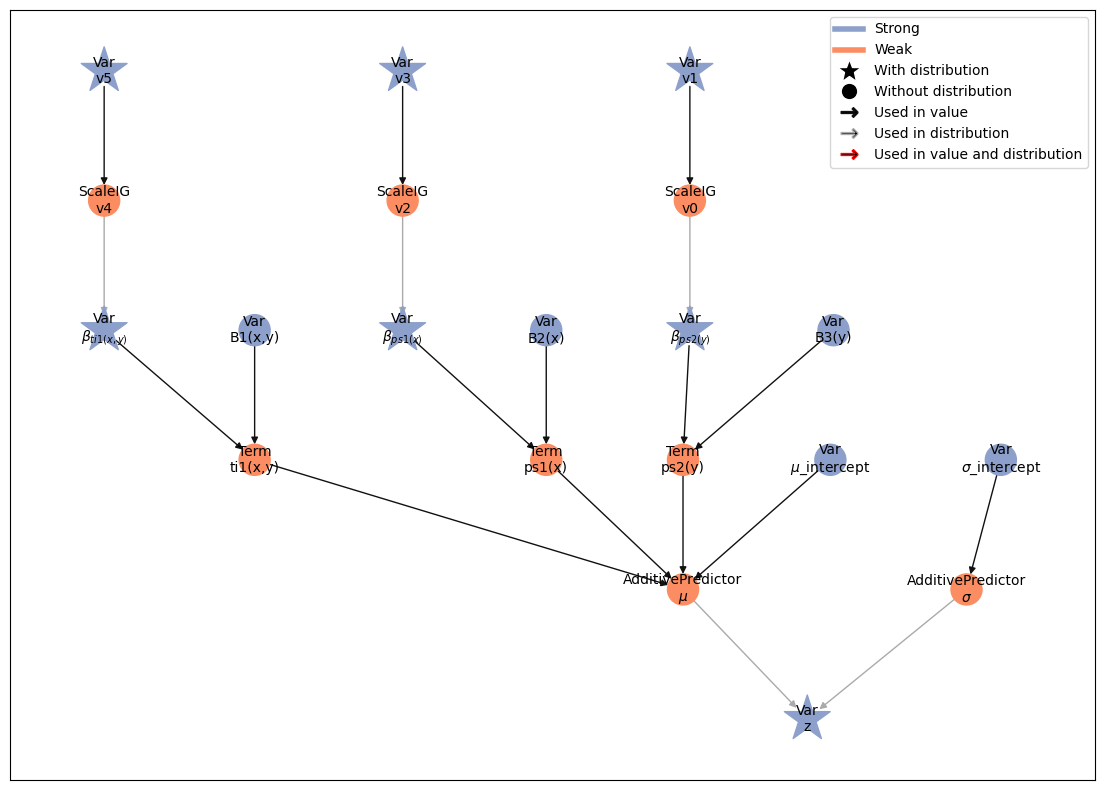

In [15]:
model.plot_vars()

In [16]:
import optax

params = [p.name for p in model.parameters.values() if not p.name.startswith("v")]
opt = gs.optim_flat(
    model, params, optimizer=optax.adam(learning_rate=1e-5), progress_bar=False
)

## Run MCMC

Since we used the `inference` arguments to specify MCMC kernels for all parameters above,
we can quickly set up the MCMC engine with `gs.LieselMCMC` (new in v0.4.0).

In [17]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=1000,
        posterior_duration=1000,
        init_duration=200,
        term_duration=200,
        thinning_posterior=5,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys 'v5', '$\\beta_{ti1(x,y)}$', 'v3', '$\\beta_{ps1(x)}$', 'v1', '$\\beta_{ps2(y)}$', '$\\mu$_intercept', '$\\sigma$_intercept'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 200 transitions, 25 jitted together
100%|██████████████████████████████████████████| 8/8 [00:05<00:00,  1.39chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|█████████████████████████████████████████| 1/1 [00:00<00:00, 760.94chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|█████████████████████████████████████████| 2/2 [00:00<00:00, 485.45chunk/s]
liesel.goose.engine - INFO - Fin

### MCMC summary

In [18]:
summary = gs.Summary(results)
summary

Parameter summary:

                             kernel      mean        sd    q_0.05     q_0.5  \
parameter          index                                                      
$\beta_{ps1(x)}$   (0,)   kernel_03 -0.017953  0.080290 -0.144877 -0.016086   
                   (1,)   kernel_03 -0.000781  0.076934 -0.122511  0.002749   
                   (2,)   kernel_03 -0.004808  0.073101 -0.126305 -0.003618   
                   (3,)   kernel_03  0.038911  0.077346 -0.078723  0.035165   
                   (4,)   kernel_03 -0.026567  0.074686 -0.144703 -0.025431   
...                             ...       ...       ...       ...       ...   
$\mu$_intercept    ()     kernel_06  0.339076  0.011633  0.320217  0.338835   
$\sigma$_intercept ()     kernel_07 -1.343859  0.032856 -1.398520 -1.343145   
v1                 ()     kernel_04  0.002147  0.001474  0.000779  0.001751   
v3                 ()     kernel_02  0.006425  0.003341  0.002834  0.005565   
v5                 ()     kernel_00  0.106043  0.018077  0.079389  0.104073   

                            q_0.95  sample_size    ess_bulk    ess_tail  \
parameter          index                                                  
$\beta_{ps1(x)}$   (0,)   0.106963          800  428.144562  556.980451   
                   (1,)   0.120106          800  435.549307  530.705620   
                   (2,)   0.114557          800  437.558353  489.126808   
                   (3,)   0.173884          800  338.311887  460.908316   
                   (4,)   0.092348          800  328.750436  608.928229   
...                            ...          ...         ...         ...   
$\mu$_intercept    ()     0.358949          800  573.542900  599.484525   
$\sigma$_intercept ()    -1.290214          800  684.923146  666.776562   
v1                 ()     0.004760          800  154.109881  309.905747   
v3                 ()     0.012733          800  292.009527  580.050025   
v5                 ()     0.138847          800  584.729523  588.774043   

                              rhat  
parameter          index            
$\beta_{ps1(x)}$   (0,)   1.008867  
                   (1,)   1.001581  
                   (2,)   1.010803  
                   (3,)   1.001003  
                   (4,)   1.009602  
...                            ...  
$\mu$_intercept    ()     1.000095  
$\sigma$_intercept ()     1.001755  
v1                 ()     1.029933  
v3                 ()     1.007290  
v5                 ()     0.999757  

[124 rows x 10 columns]

### MCMC trace plots

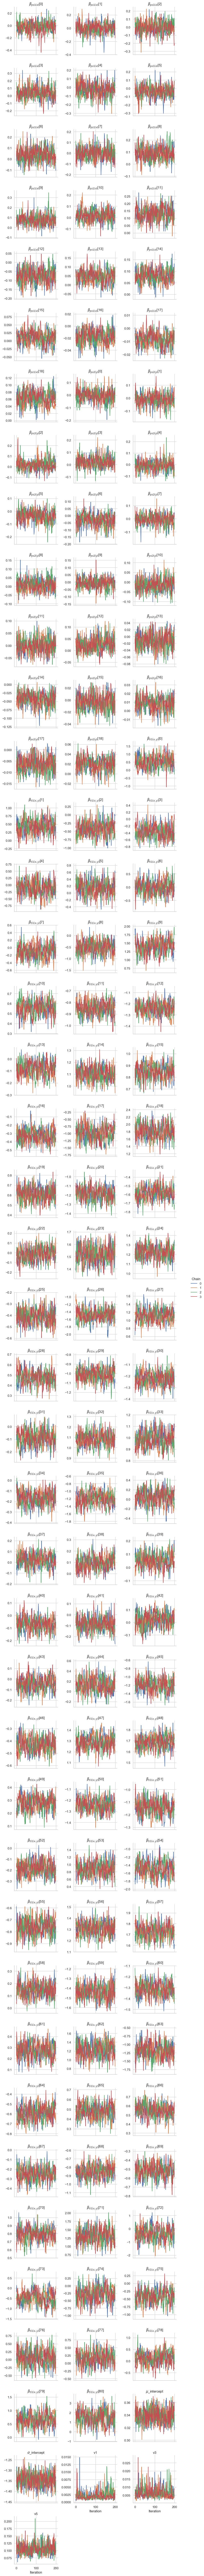

In [19]:
gs.plot_trace(results)

## Predictions

In [20]:
samples = results.get_posterior_samples()

In [23]:
newdata = {"x": df_grid.x.to_numpy(), "y": df_grid.y.to_numpy()}
newdata = evaluate_bases(newdata, bases_model)

### Predict variables at new x values

In [24]:
predictions = model.predict(  # new in liesel v0.4.0
    samples=samples,
    predict=["ti1(x,y)", "$\\mu$", "ps1(x)", "ps2(y)"],
    newdata=newdata,
)

predictions_summary = (
    gs.SamplesSummary(predictions).to_dataframe().reset_index()
)  # new in liesel v0.4.0

In [25]:
predictions_summary["x"] = np.tile(df_grid.x.to_numpy(), len(predictions))
predictions_summary["y"] = np.tile(df_grid.y.to_numpy(), len(predictions))

In [26]:
predictions_summary.head()

variable   var_fqn var_index  sample_size      mean       var        sd  \
0    $\mu$  $\mu$[0]      (0,)          800  0.226181  0.229260  0.478811   
1    $\mu$  $\mu$[1]      (1,)          800 -0.129758  0.221622  0.470767   
2    $\mu$  $\mu$[2]      (2,)          800 -0.316867  0.347780  0.589729   
3    $\mu$  $\mu$[3]      (3,)          800 -0.353339  0.455900  0.675204   
4    $\mu$  $\mu$[4]      (4,)          800 -0.266663  0.485071  0.696471   

       rhat    ess_bulk    ess_tail  mcse_mean   mcse_sd    q_0.05     q_0.5  \
0  1.013615  232.972403  470.396984   0.031422  0.014522 -0.522399  0.224218   
1  1.026474  133.066125  316.899702   0.040626  0.020514 -0.901560 -0.114737   
2  1.023617  106.349874  242.498344   0.056782  0.027420 -1.347242 -0.298375   
3  1.020745  106.121941  246.926549   0.065129  0.031787 -1.552361 -0.340395   
4  1.023114  106.793829  319.771101   0.067083  0.032846 -1.478709 -0.249582   

     q_0.95   hdi_low  hdi_high         x    y  
0  1.002413 -0.516122  1.007872  0.000000  0.0  
1  0.646163 -0.901123  0.650504  0.014286  0.0  
2  0.634383 -1.347208  0.634929  0.028571  0.0  
3  0.734509 -1.438436  0.794950  0.042857  0.0  
4  0.843121 -1.439123  0.868374  0.057143  0.0

### Plot fitted functions

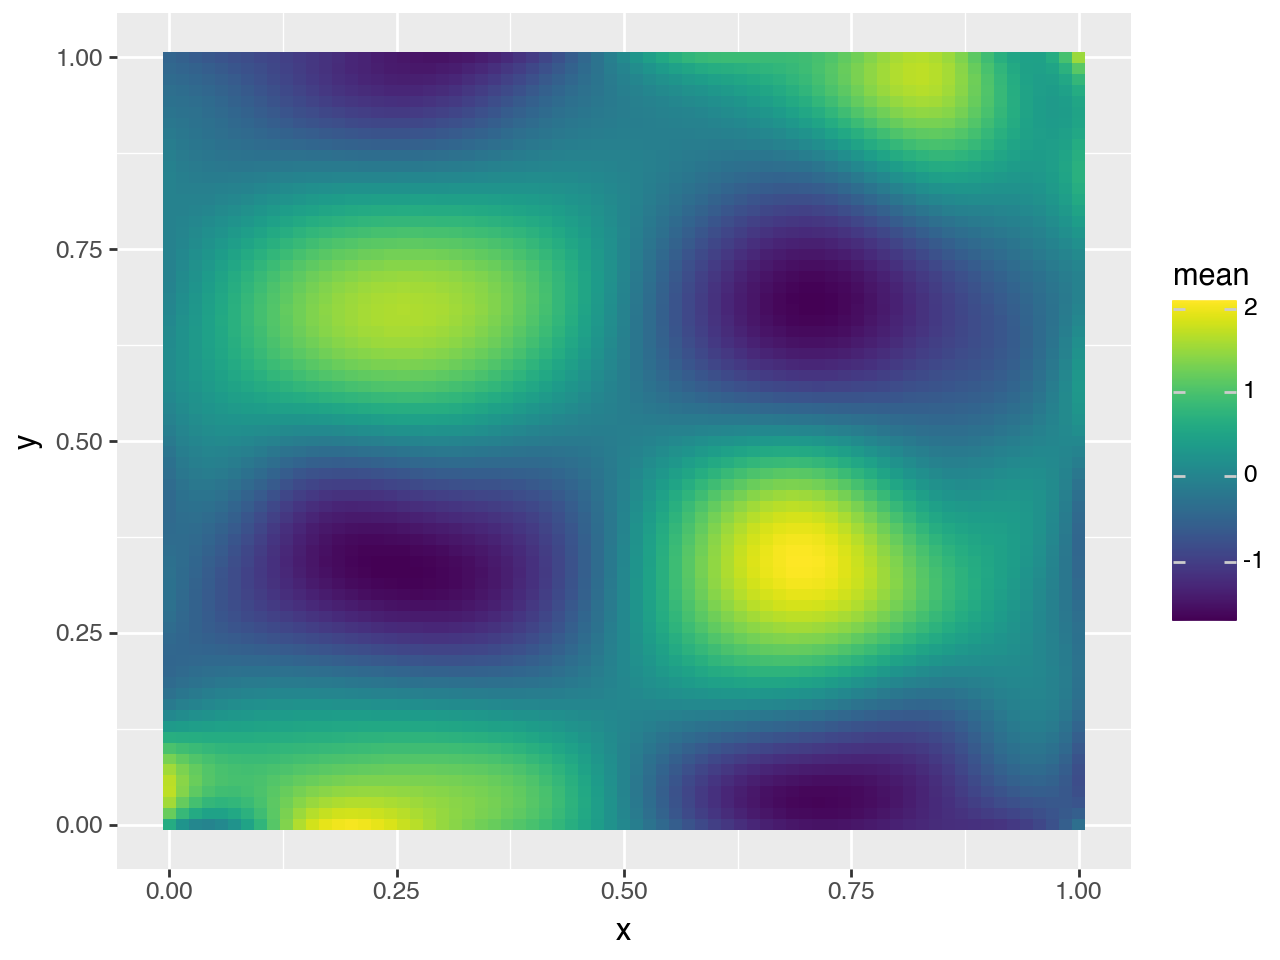

In [27]:
select = predictions_summary["variable"].isin(["ti1(x,y)"])
(p9.ggplot(predictions_summary[select]) + p9.geom_tile(p9.aes("x", "y", fill="mean")))

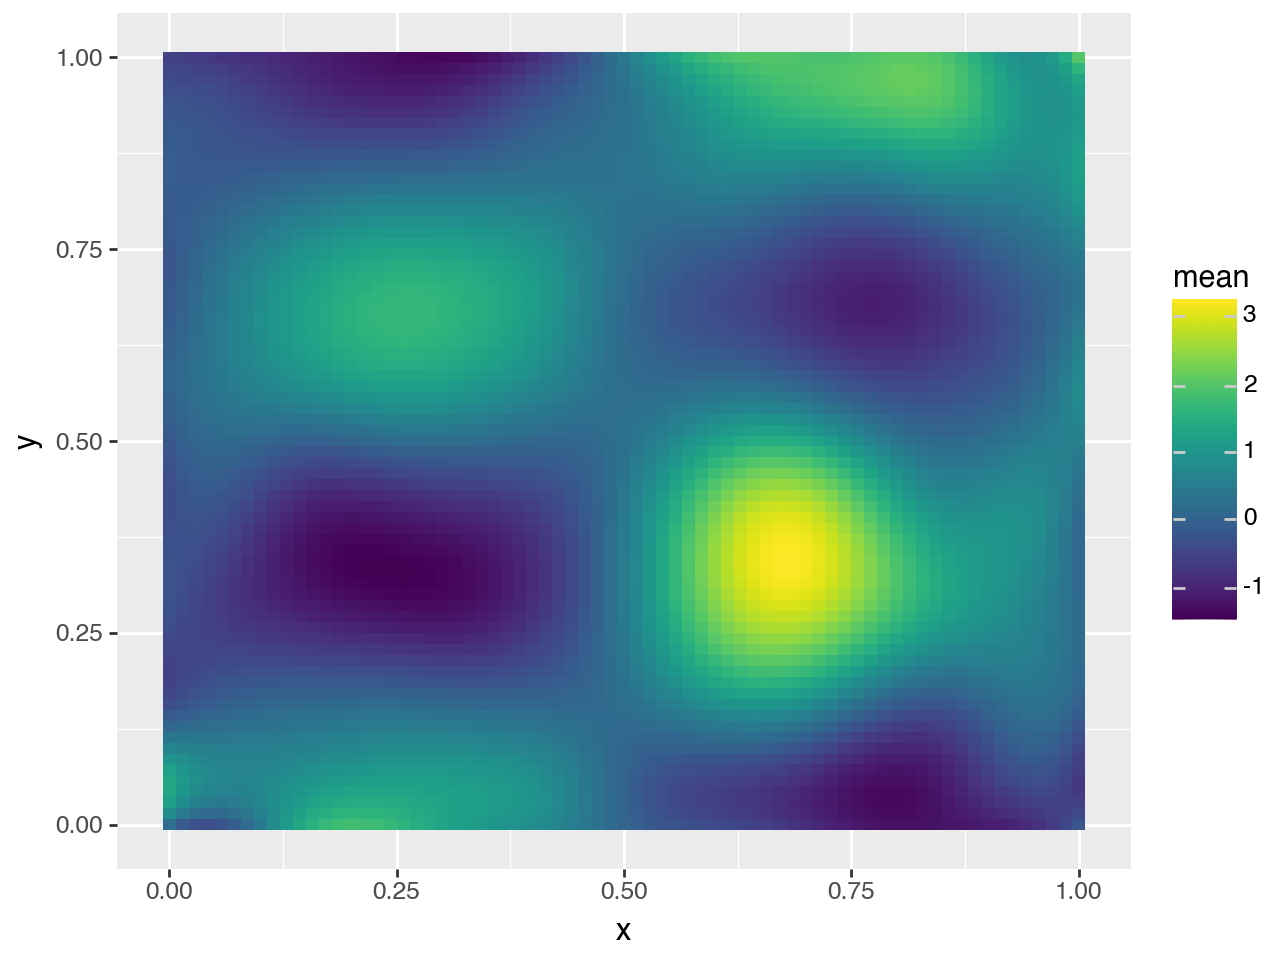

In [28]:
select = predictions_summary["variable"].isin(["$\\mu$"])
(p9.ggplot(predictions_summary[select]) + p9.geom_tile(p9.aes("x", "y", fill="mean")))

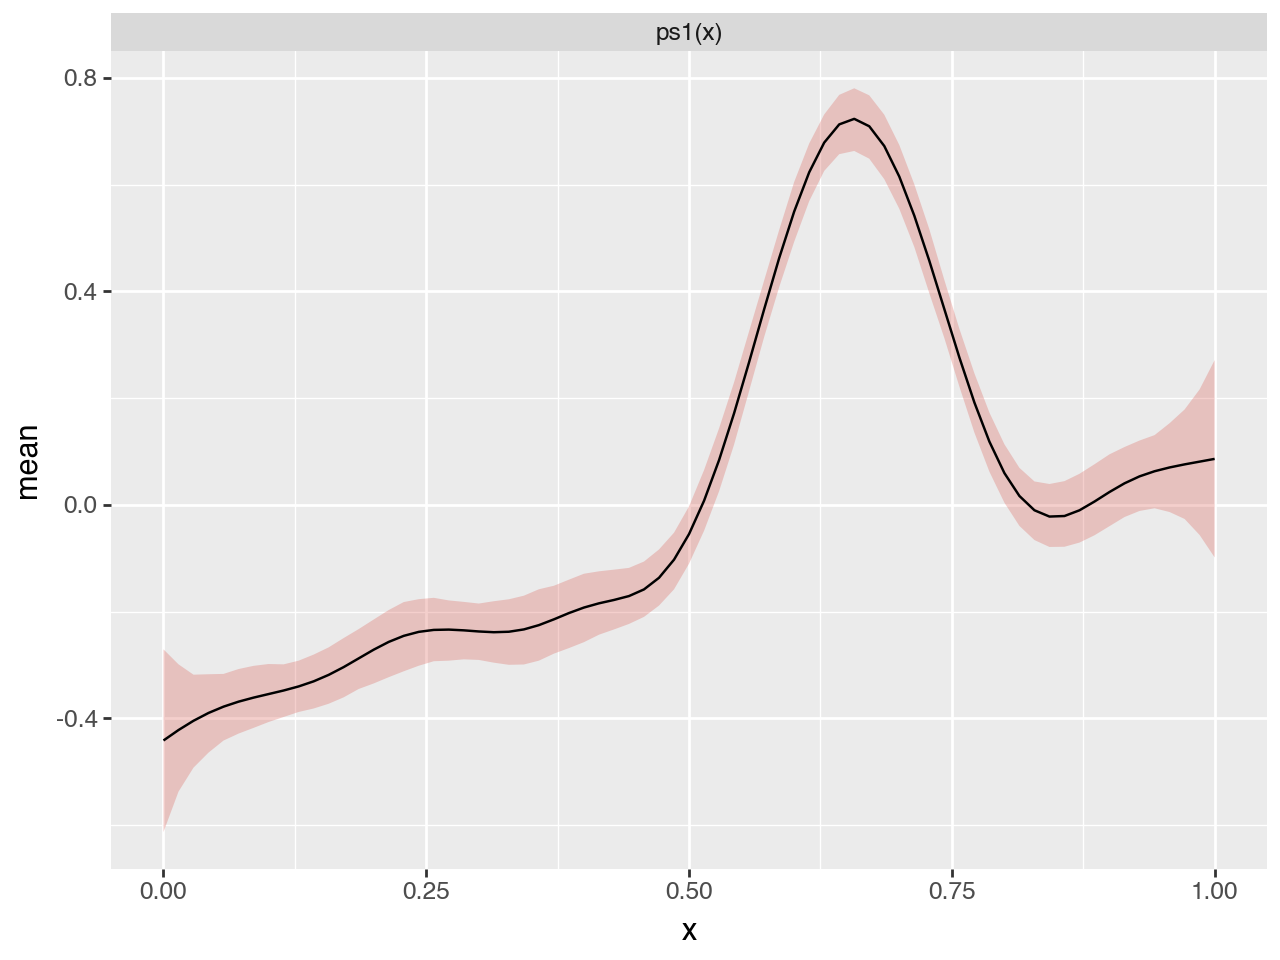

In [29]:
select = predictions_summary["variable"].isin(["ps1(x)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("x", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("x", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)

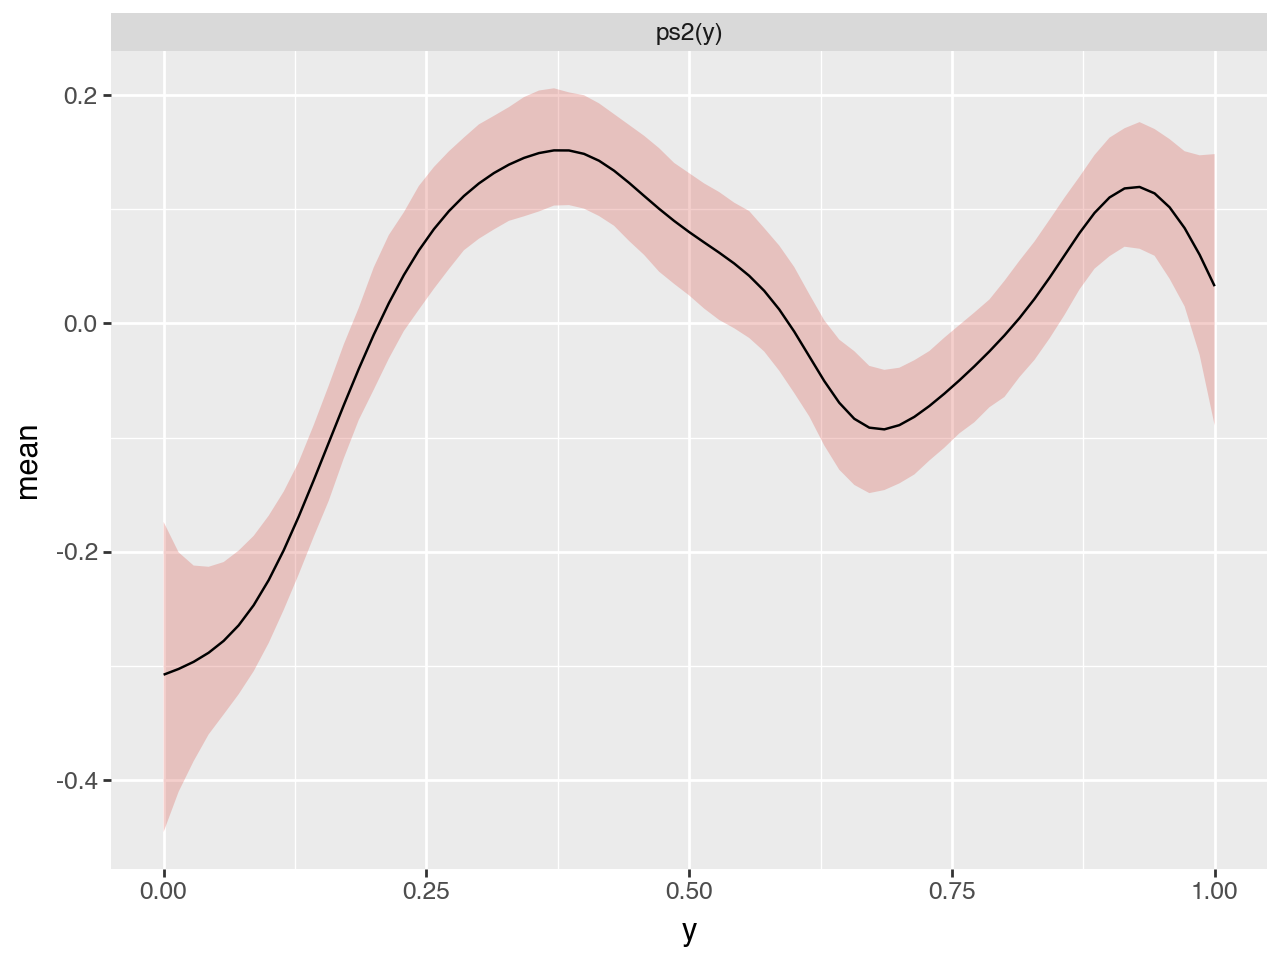

In [30]:
select = predictions_summary["variable"].isin(["ps2(y)"])
(
    p9.ggplot(predictions_summary[select])
    + p9.geom_ribbon(
        p9.aes("y", ymin="q_0.05", ymax="q_0.95", fill="variable"), alpha=0.3
    )
    + p9.geom_line(p9.aes("y", "mean"))
    + p9.facet_wrap("~variable", scales="free_y", ncol=1)
    + p9.guides(fill="none")
)